# **BUSINESS CASE 2: SIEMENS ADVANTA SALES FORECASTING**  


## 🎓 Master’s Program in Data Science & Advanced Analytics 
**Nova IMS** | March 2025   
**Course:** Business Cases with Data Science

## 👥 Team **Group A**  
- **Alice Viegas** | 20240572  
- **Bernardo Faria** | 20240579  
- **Dinis Pinto** | 20240612  
- **Daan van Holten** | 20240681
- **Philippe Dutranoit** | 20240518

## 📊 Goal of the notebook

this notebook is used to predict the market data over 10 months and perform some feature selction 

# imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

# importing relevant 
from Functions import *

import importlib
imported_module = importlib.import_module("Functions")
importlib.reload(imported_module)


<module 'Functions' from '/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Functions.py'>

In [3]:
df_market = pd.read_csv('../Data/df_market.csv')
info_market = pd.read_csv('../Data/info_market.csv')
filtered_market = pd.read_csv('../Data/filtered_info_market.csv')

sales_agg1 = pd.read_csv('../Data/sales_agg1.csv')
sales_agg3 = pd.read_csv('../Data/sales_agg3.csv')
sales_agg4 = pd.read_csv('../Data/sales_agg4.csv')
sales_agg5 = pd.read_csv('../Data/sales_agg5.csv')
sales_agg6 = pd.read_csv('../Data/sales_agg6.csv')
sales_agg8 = pd.read_csv('../Data/sales_agg8.csv')
sales_agg9 = pd.read_csv('../Data/sales_agg9.csv')
sales_agg11 = pd.read_csv('../Data/sales_agg11.csv')
sales_agg12 = pd.read_csv('../Data/sales_agg12.csv')
sales_agg13 = pd.read_csv('../Data/sales_agg13.csv')
sales_agg14 = pd.read_csv('../Data/sales_agg14.csv')
sales_agg16 = pd.read_csv('../Data/sales_agg16.csv')
sales_agg20 = pd.read_csv('../Data/sales_agg20.csv')
sales_agg36 = pd.read_csv('../Data/sales_agg36.csv')

In [4]:
# extract a list of index codes that were find relevant in the preevious notebook
index_codes = filtered_market["Index Code"].tolist()
# only select the columns that were find relevant
df_market = df_market[["date"]+ index_codes]
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 219 non-null    object 
 1   MAB_ELE_PRO156       219 non-null    float64
 2   MAB_ELE_SHP156       219 non-null    float64
 3   MAB_ELE_SHP250       219 non-null    float64
 4   MAB_ELE_PRO392       219 non-null    float64
 5   MAB_ELE_SHP392       219 non-null    float64
 6   MAB_ELE_SHP826       201 non-null    float64
 7   MAB_ELE_SHP840       218 non-null    float64
 8   RohiBASEMET1000_org  219 non-null    float64
 9   RohiMETMIN1000_org   219 non-null    float64
 10  RohiNATGAS1000_org   219 non-null    float64
 11  RohCOPPER1000_org    219 non-null    float64
 12  WKLWEUR840_org       219 non-null    float64
 13  PRI27840_org         219 non-null    float64
 14  PRI27826_org         201 non-null    float64
 15  PRI27380_org         219 non-null    flo

**To change with the right predictor**

In [5]:
from prophet import Prophet
def forecast_market_features_prophet(market_df, date_column='date', forecast_horizon=10, plot=True):
    """
    Forecasts each column (market feature) in the DataFrame for the next N months using Facebook Prophet.

    Parameters:
        market_df (pd.DataFrame): Market data with datetime column and multiple numeric columns.
        date_column (str): Name of the datetime column.
        forecast_horizon (int): Number of future periods (months) to forecast.
        plot (bool): Whether to plot the forecasts.

    Returns:
        dict: {feature_name: forecast_dataframe_with_future_values}
    """
    forecasts = {}
    market_df = market_df.copy()
    market_df[date_column] = pd.to_datetime(market_df[date_column])
    market_df = market_df.set_index(date_column).asfreq("MS")  # Monthly Start

    for feature in market_df.columns:
        series = market_df[feature].dropna()

        # Format data for Prophet
        df_prophet = pd.DataFrame({
            'ds': series.index,
            'y': series.values
        })

        model = Prophet(yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                        seasonality_mode='multiplicative',
                        changepoint_prior_scale=0.5)  # Try 0.2, 0.5, 1.0
        model.fit(df_prophet)

        # Future dataframe
        future = model.make_future_dataframe(periods=forecast_horizon, freq='MS')
        forecast = model.predict(future)

        # Store only the forecasted part
        forecast_feature = forecast[['ds', 'yhat']].set_index('ds').iloc[-forecast_horizon:]
        forecasts[feature] = forecast_feature

        # Plot
        if plot:
            plt.figure(figsize=(10, 4))
            plt.plot(df_prophet['ds'], df_prophet['y'], label='History')
            plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
            plt.title(f"Forecast for '{feature}' using Prophet")
            plt.xlabel("Date")
            plt.ylabel("Value")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return forecasts


15:59:31 - cmdstanpy - INFO - Chain [1] start processing
15:59:31 - cmdstanpy - INFO - Chain [1] done processing


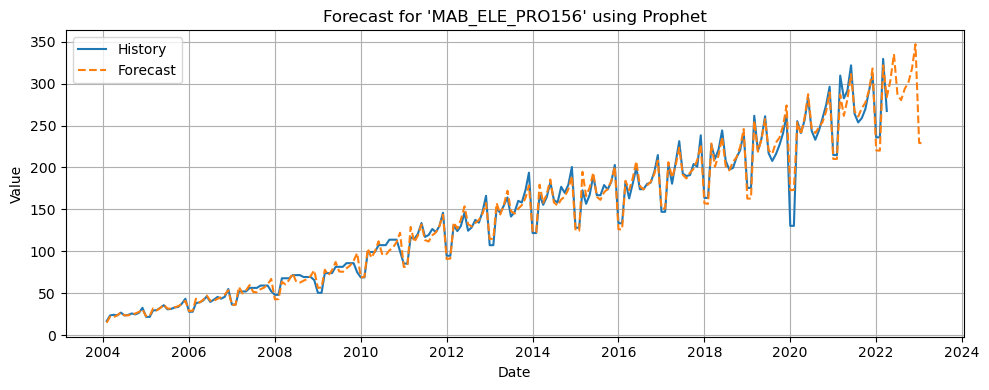

15:59:31 - cmdstanpy - INFO - Chain [1] start processing
15:59:31 - cmdstanpy - INFO - Chain [1] done processing


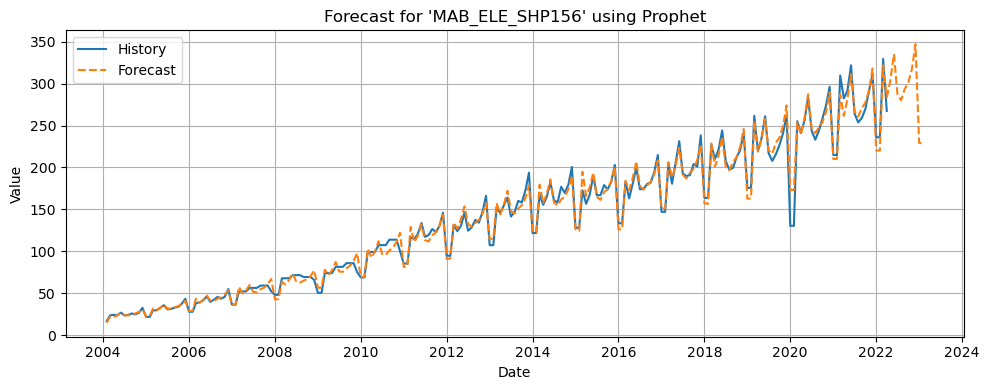

15:59:31 - cmdstanpy - INFO - Chain [1] start processing
15:59:31 - cmdstanpy - INFO - Chain [1] done processing


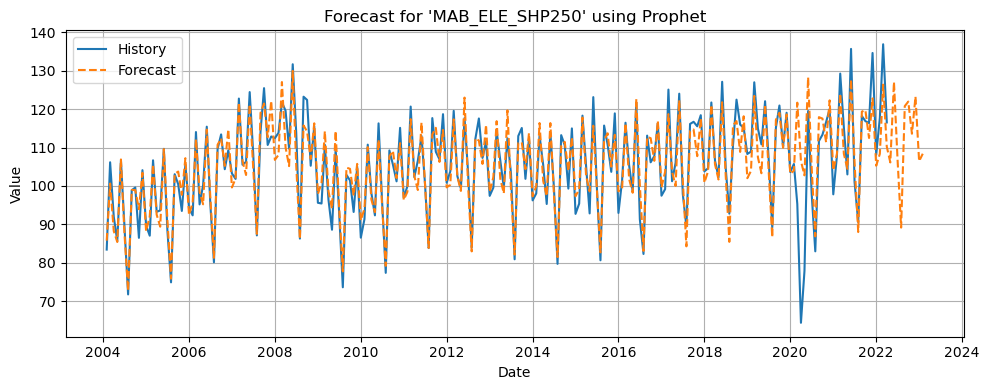

15:59:32 - cmdstanpy - INFO - Chain [1] start processing
15:59:32 - cmdstanpy - INFO - Chain [1] done processing


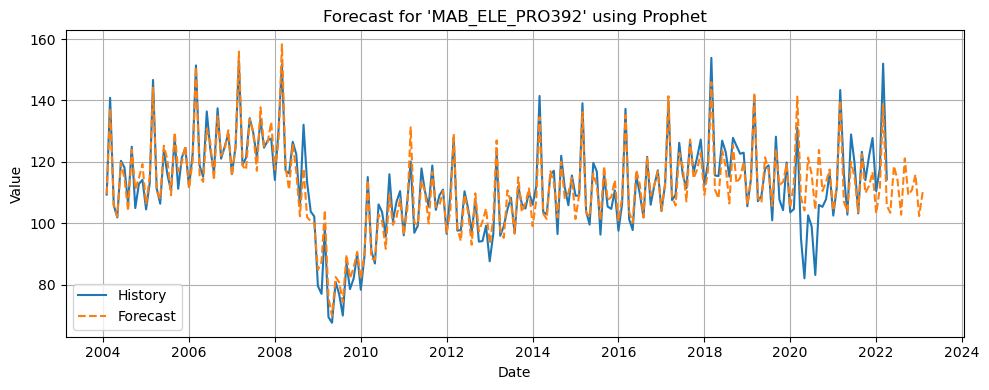

15:59:32 - cmdstanpy - INFO - Chain [1] start processing
15:59:32 - cmdstanpy - INFO - Chain [1] done processing


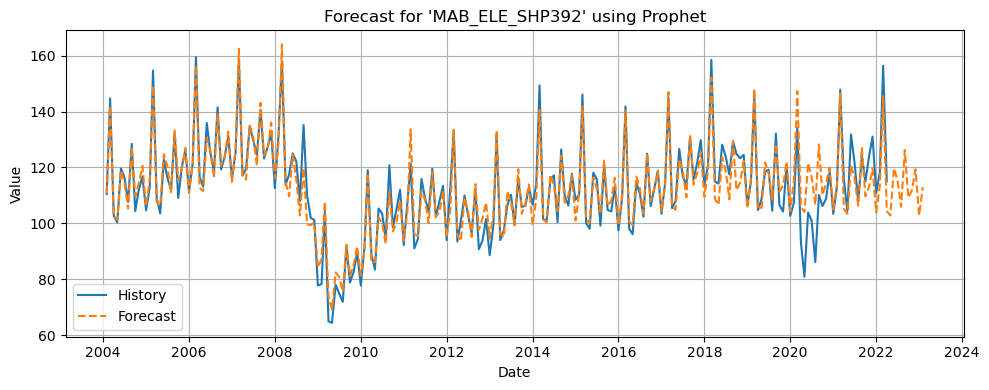

15:59:32 - cmdstanpy - INFO - Chain [1] start processing
15:59:32 - cmdstanpy - INFO - Chain [1] done processing


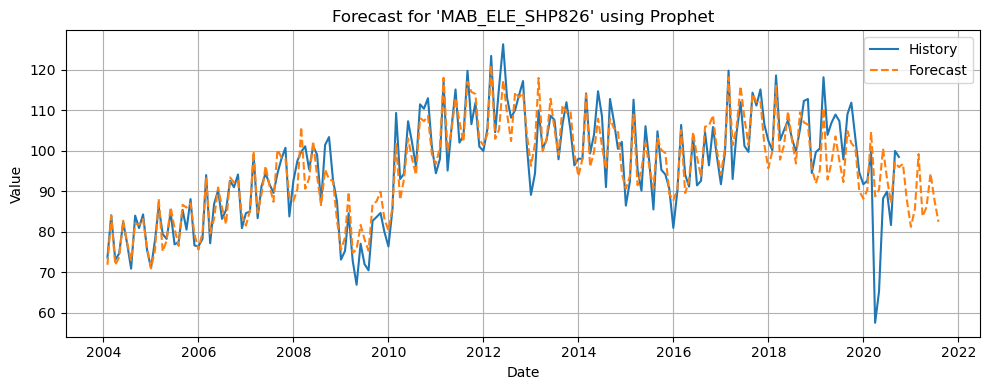

15:59:32 - cmdstanpy - INFO - Chain [1] start processing
15:59:32 - cmdstanpy - INFO - Chain [1] done processing


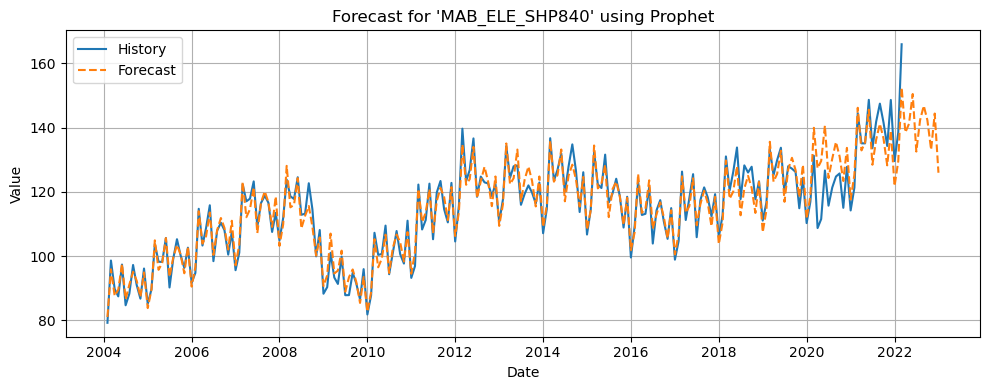

15:59:32 - cmdstanpy - INFO - Chain [1] start processing
15:59:32 - cmdstanpy - INFO - Chain [1] done processing


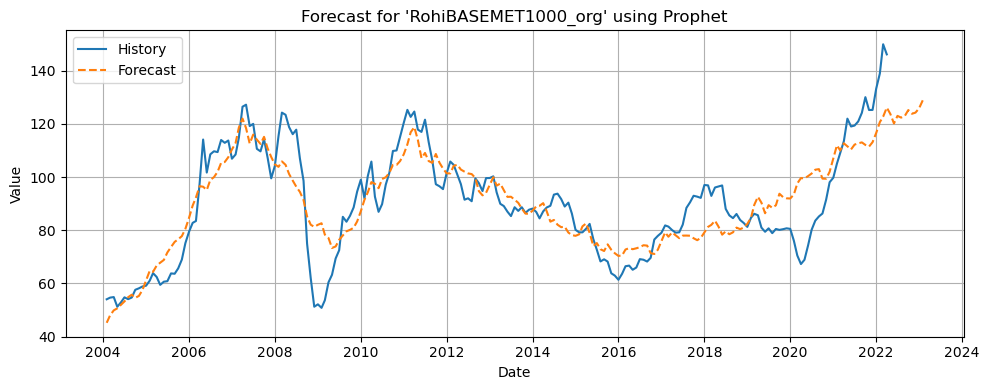

15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:33 - cmdstanpy - INFO - Chain [1] done processing


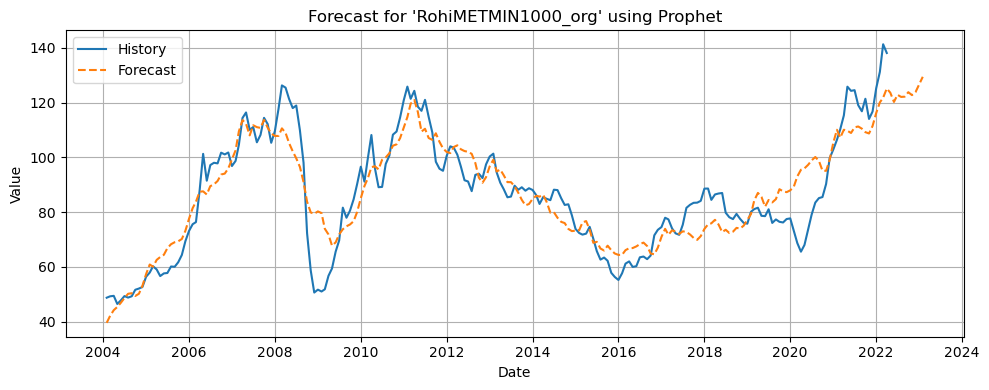

15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:33 - cmdstanpy - INFO - Chain [1] done processing


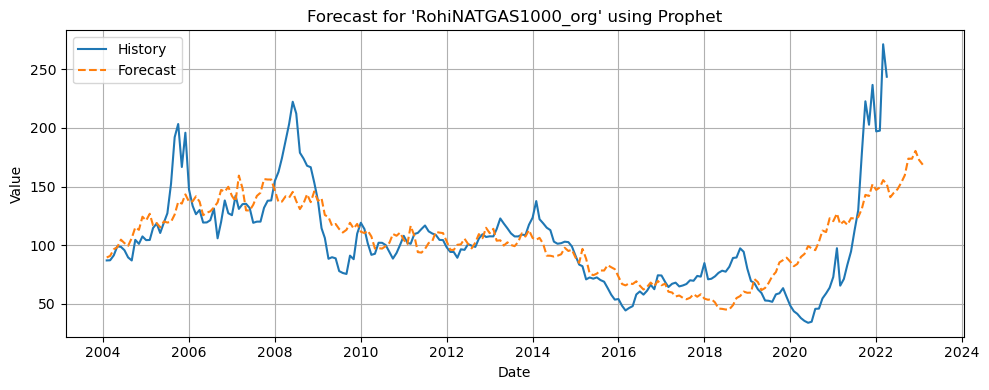

15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:33 - cmdstanpy - INFO - Chain [1] done processing


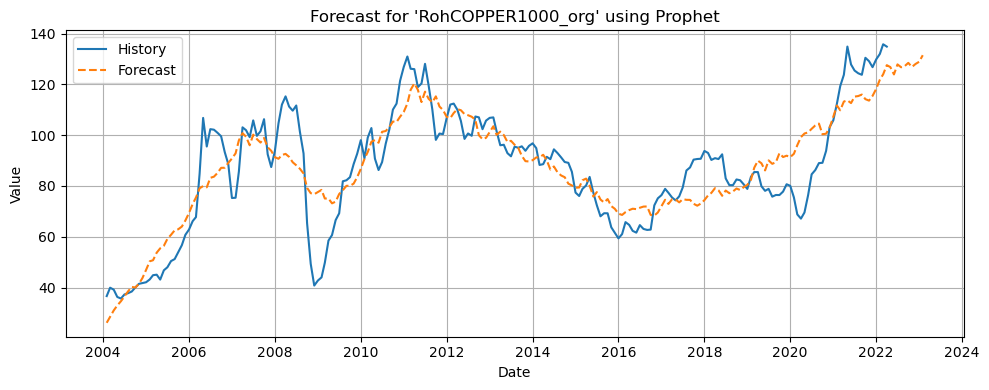

15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:33 - cmdstanpy - INFO - Chain [1] done processing


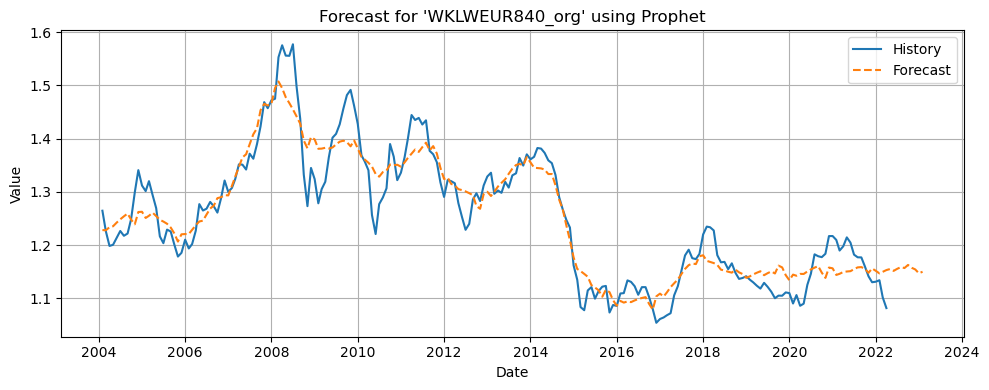

15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:33 - cmdstanpy - INFO - Chain [1] done processing


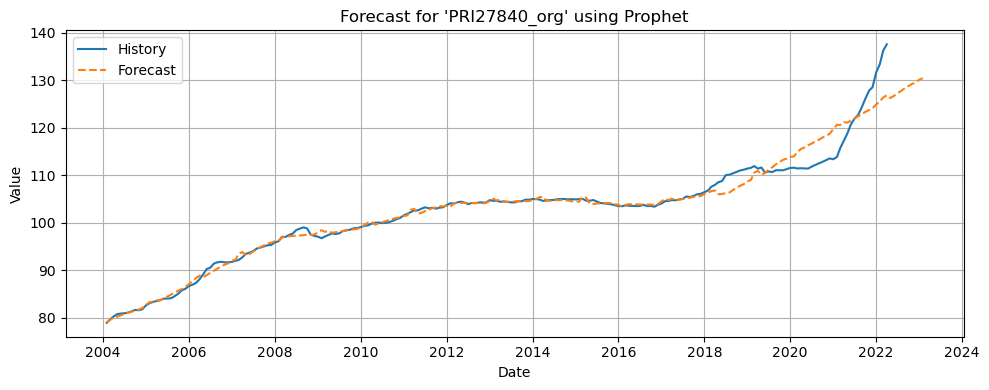

15:59:34 - cmdstanpy - INFO - Chain [1] start processing
15:59:34 - cmdstanpy - INFO - Chain [1] done processing


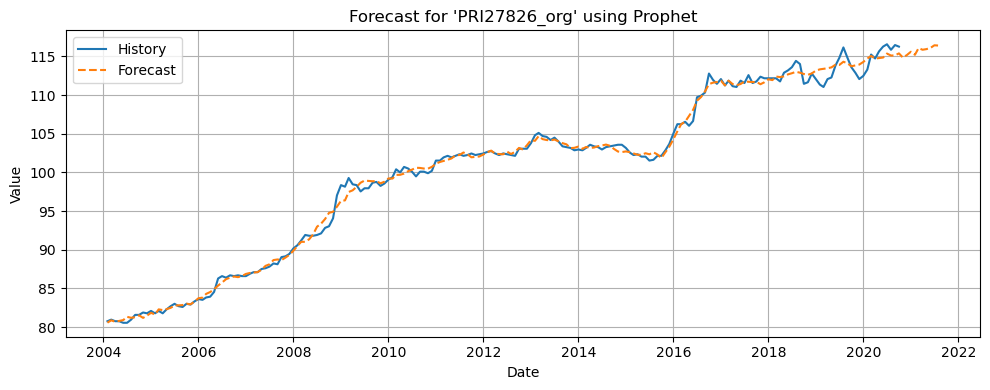

15:59:34 - cmdstanpy - INFO - Chain [1] start processing
15:59:34 - cmdstanpy - INFO - Chain [1] done processing


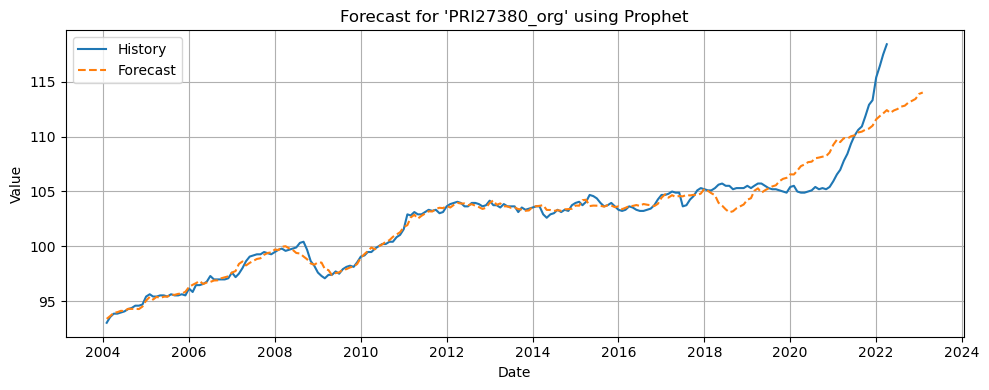

15:59:34 - cmdstanpy - INFO - Chain [1] start processing
15:59:34 - cmdstanpy - INFO - Chain [1] done processing


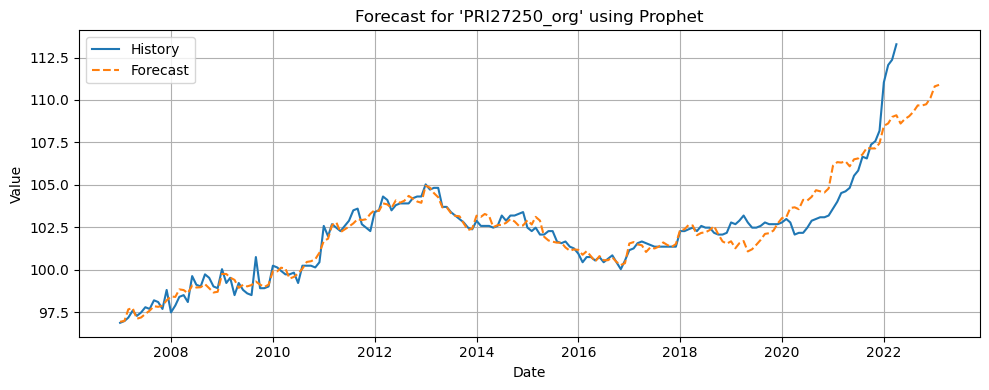

15:59:34 - cmdstanpy - INFO - Chain [1] start processing
15:59:34 - cmdstanpy - INFO - Chain [1] done processing


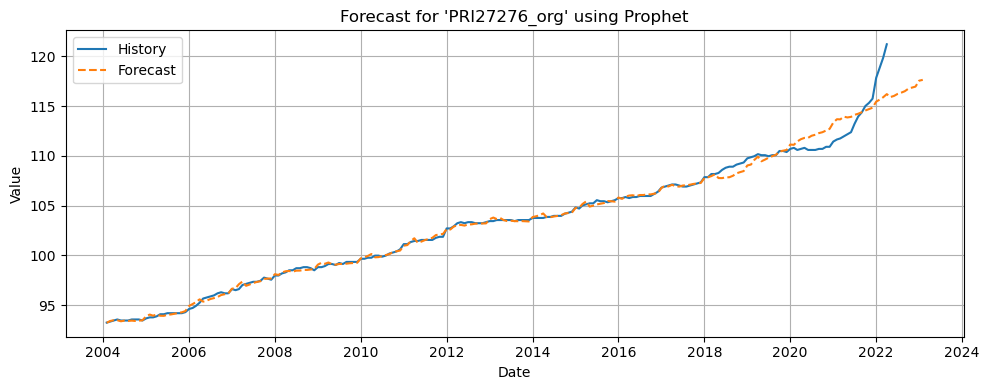

15:59:34 - cmdstanpy - INFO - Chain [1] start processing
15:59:34 - cmdstanpy - INFO - Chain [1] done processing


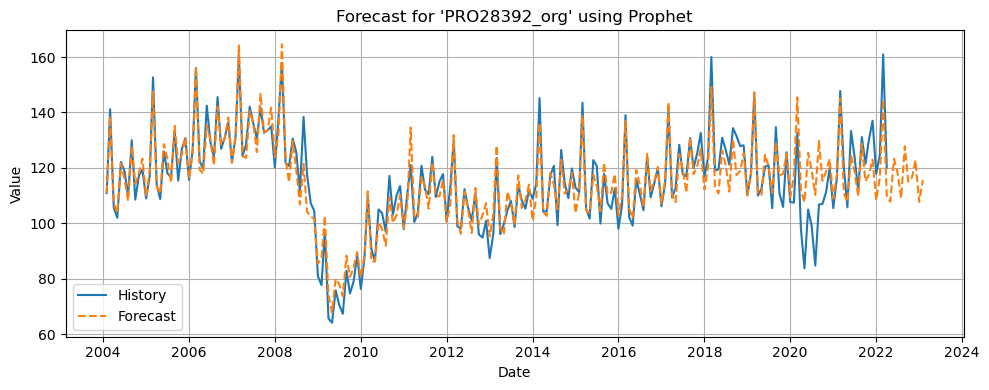

15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing


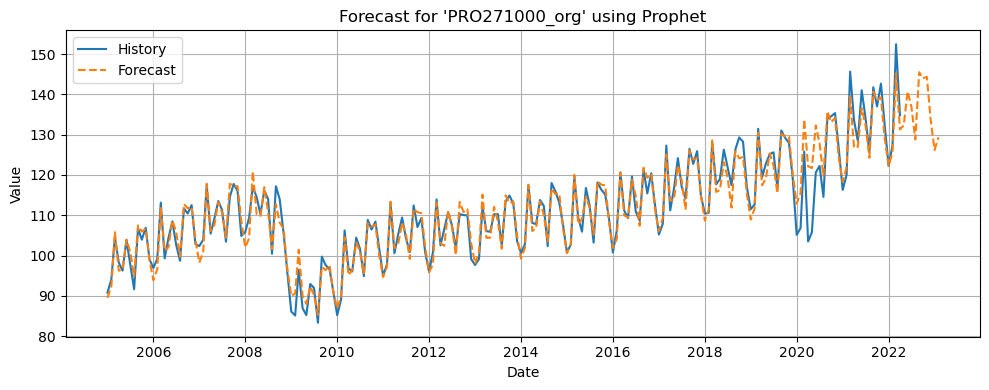

15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing


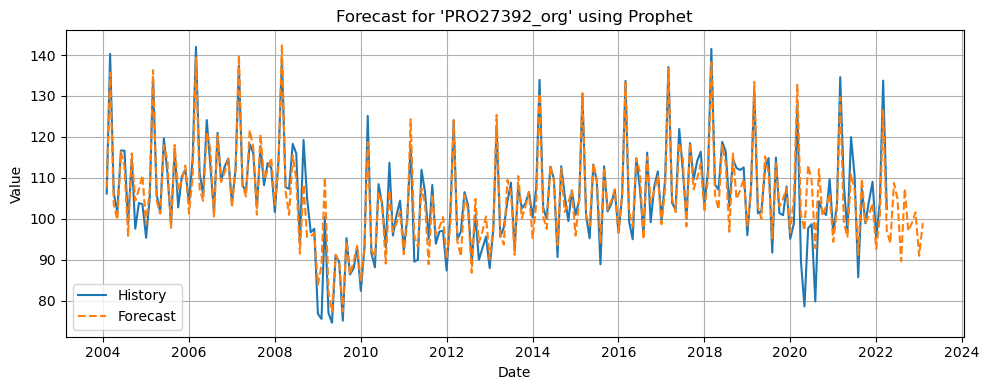

In [6]:
forcast = forecast_market_features_prophet(df_market, date_column='date', forecast_horizon=10, plot=True)

In [7]:
def append_forecasts_to_market_df(market_df, forecasts, date_column='date'):
    """
    Appends 10-month forecasts to market_df using forecast results per feature.

    Parameters:
        market_df (pd.DataFrame): Original market data.
        forecasts (dict): Dictionary of {feature: pd.Series or pd.DataFrame} with date index.
        date_column (str): Name of the datetime column in original market_df.

    Returns:
        pd.DataFrame: market_df extended with forecasted rows.
    """
    # Make sure the original date column is datetime and index is set
    df = market_df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column).asfreq("MS")

    # Create empty DataFrame for forecasts
    forecast_df = pd.DataFrame(index=next(iter(forecasts.values())).index)

    for feature, forecast_series in forecasts.items():
        if isinstance(forecast_series, pd.DataFrame):
            forecast_df[feature] = forecast_series['yhat']
        else:
            forecast_df[feature] = forecast_series

    # Combine original + forecasted data
    extended_df = pd.concat([df, forecast_df])
    extended_df = extended_df.reset_index().rename(columns={'index': date_column})

    return extended_df


In [8]:
extended_df = append_forecasts_to_market_df(df_market, forcast, date_column='date')
extended_df.tail(15)

,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_SHP826,MAB_ELE_SHP840,RohiBASEMET1000_org,RohiMETMIN1000_org,...,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRO28392_org,PRO271000_org,PRO27392_org
214,2021-12-01,310.763183,310.763183,134.589504,127.771735,131.029703,NaN,148.590371,125.207030,116.715183,...,126.761240,1.130400,128.511261,NaN,113.309631,108.182510,115.748863,136.975506,132.281006,109.005151
215,2022-01-01,235.956129,235.956129,108.156320,110.460181,110.823532,NaN,129.565798,133.219393,125.229641,...,129.829146,1.131400,131.628510,NaN,115.390617,111.037476,117.853386,117.861377,122.236023,95.369065
216,2022-02-01,235.956129,235.956129,117.715770,117.879631,118.300232,NaN,138.560330,138.905572,131.176501,...,131.963648,1.134200,133.342178,NaN,116.431107,112.057098,118.905647,124.710859,127.373421,103.950687
217,2022-03-01,329.413367,329.413367,136.858720,152.000561,156.400634,NaN,165.926217,149.890871,141.283339,...,135.782207,1.101900,136.153778,NaN,117.471596,112.362991,119.852684,160.954233,152.452942,133.743932
218,2022-04-01,267.373145,267.373145,116.528738,114.262328,115.012049,NaN,NaN,146.090998,138.094143,...,134.859685,1.081900,137.531616,NaN,118.408043,113.280655,121.220627,120.098810,134.843353,102.361680
219,2022-05-01,303.250728,303.250728,106.131520,103.404173,102.781120,NaN,141.148174,123.723859,123.589252,...,126.807820,1.155148,126.227258,NaN,112.155378,108.609602,115.910143,107.803413,132.332725,94.029013
220,2022-06-01,335.155927,335.155927,127.082442,118.646475,119.730934,NaN,150.442746,120.117506,120.224641,...,123.903504,1.151725,126.660538,NaN,112.378626,108.877516,116.023938,123.272679,140.765272,108.735673
221,2022-07-01,286.561212,286.561212,107.214611,114.109414,115.468442,NaN,132.537200,122.970510,122.828745,...,127.848598,1.155531,127.215683,NaN,112.506004,109.034340,116.220888,118.373574,136.940502,104.895335
222,2022-08-01,280.318460,280.318460,89.181918,102.766226,105.912673,NaN,142.276818,122.319926,122.053195,...,126.732462,1.158783,127.723182,NaN,112.723883,109.301780,116.349544,109.116096,128.828804,89.626257
223,2022-09-01,293.926970,293.926970,120.773052,121.138124,126.210733,NaN,146.787403,122.923200,122.152996,...,127.204848,1.157089,128.271022,NaN,112.807551,109.677686,116.497874,127.735775,145.518984,107.347482


In [9]:
nan_rows = extended_df[extended_df.isna().any(axis=1) & (extended_df['date'] > "2017-01-01")]
nan_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 201 to 228
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 28 non-null     datetime64[ns]
 1   MAB_ELE_PRO156       28 non-null     float64       
 2   MAB_ELE_SHP156       28 non-null     float64       
 3   MAB_ELE_SHP250       28 non-null     float64       
 4   MAB_ELE_PRO392       28 non-null     float64       
 5   MAB_ELE_SHP392       28 non-null     float64       
 6   MAB_ELE_SHP826       0 non-null      float64       
 7   MAB_ELE_SHP840       26 non-null     float64       
 8   RohiBASEMET1000_org  28 non-null     float64       
 9   RohiMETMIN1000_org   28 non-null     float64       
 10  RohiNATGAS1000_org   28 non-null     float64       
 11  RohCOPPER1000_org    28 non-null     float64       
 12  WKLWEUR840_org       28 non-null     float64       
 13  PRI27840_org         28 non-null     fl

# Preparing the market data for models

we only take the values after 2017 as we don't need as much data as the sales data start in 2018
 
we also drop the coloumn with to many missing values as rightfully imputing them will be difficult and might not be usefull (for future interation and if the project is selected by the business we will manage to find a way to deal with them more effectivly )

In [11]:
df_market = extended_df[(extended_df['date'] > "2017-01-01")]
df_market.drop (columns = ["PRI27826_org","MAB_ELE_SHP826"], inplace = True)
df_market.fillna(method='ffill', inplace=True)

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_50310/3227762723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market.drop (columns = ["PRI27826_org","MAB_ELE_SHP826"], inplace = True)
/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_50310/3227762723.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_market.fillna(method='ffill', inplace=True)
/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_50310/3227762723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market.fillna(method='f

In [ ]:
## next step will be to lag the data based on the previous notebook cross corrlation analysis

# Product 1

In [13]:
# fit model on training data
model = XGBRegressor(random_state=1)
model.fit(lag_data5.iloc[:,:51], lag_data5.iloc[:,51])
# feature importance
importance_5=pd.DataFrame(index=lag_data5.iloc[:,:51].columns, data=model.feature_importances_)
importance_5.head()

NameError: name 'XGBRegressor' is not defined